In [1]:
import os
import pandas as pd
import fuzzymatcher
from mplsoccer.pitch import Pitch, VerticalPitch
import matplotlib.pyplot as plt
import shapely.geometry as geom
import numpy as np

Load the data

In [2]:
cwd = os.getcwd()
STATSBOMB_SHOTS = os.path.join(cwd, 'data', 'statsbomb', 'shots.parquet')
WYSCOUT_SHOTS = os.path.join(cwd, 'data', 'wyscout', 'shots.parquet')
FREEZE_FEATURES = os.path.join(cwd, 'data', 'statsbomb', 'freeze_features.parquet')
df_statsbomb_shots = pd.read_parquet(STATSBOMB_SHOTS)
df_wyscout_shots = pd.read_parquet(WYSCOUT_SHOTS)
df_freeze_frame = pd.read_parquet(FREEZE_FEATURES)

Remove three shots without player info

In [3]:
df_wyscout_shots = df_wyscout_shots[df_wyscout_shots.player_id.notnull()].copy()

Get a unique team id by combining the datasets and using a fuzzy match on team name

In [4]:
cols = ['team_id', 'team_name', 'competition_gender']
a = df_wyscout_shots[cols].drop_duplicates('team_id', keep='last').rename({'team_id': 'wyscout_team_id'}, axis=1).copy()
b = df_statsbomb_shots[cols].drop_duplicates('team_id', keep='last').rename({'team_id': 'statsbomb_team_id'}, axis=1).copy()
team_match = fuzzymatcher.fuzzy_left_join(a,
                                          b,
                                          left_on=['team_name', 'competition_gender'],
                                          right_on=['team_name', 'competition_gender'],
                                          left_id_col='wyscout_team_id',
                                          right_id_col='statsbomb_team_id')
team_match = team_match[(team_match.best_match_score > 0.02) & (team_match.competition_gender_right == 'male')].copy()
team_match = (team_match[['wyscout_team_id', 'statsbomb_team_id', 'competition_gender_right', 'team_name_right']]
              .rename({'team_name_right': 'team_name', 'competition_gender_right': 'competition_gender'}, axis=1)
              .copy())
df_team = pd.concat([a[~a.wyscout_team_id.isin(team_match.wyscout_team_id)],
                     b[~b.statsbomb_team_id.isin(team_match.statsbomb_team_id)],
                     team_match])
df_team.reset_index(drop=True, inplace=True)
df_team.index.name = 'team_id'
df_team.reset_index(inplace=True)
df_team

,team_id,wyscout_team_id,team_name,competition_gender,statsbomb_team_id
0,0,14496.0,Slovakia,male,NaN
1,1,4687.0,Turkey,male,NaN
2,2,3757.0,Italy,male,NaN
3,3,10451.0,Hungary,male,NaN
4,4,14622.0,Ukraine,male,NaN
...,...,...,...,...,...
217,217,1625.0,Manchester City,male,36.0
218,218,678.0,Athletic Bilbao,male,215.0
219,219,1612.0,Liverpool,male,24.0
220,220,698.0,Getafe,male,216.0


Add the unique team_id/ name to the datasets

In [5]:
# wyscout
a = df_team[['team_id', 'wyscout_team_id', 'team_name']].copy()
df_wyscout_shots.rename({'team_id': 'wyscout_team_id'}, axis=1, inplace=True)
df_wyscout_shots.drop('team_name', axis=1, inplace=True)
df_wyscout_shots = df_wyscout_shots.merge(a, how='left', on='wyscout_team_id')
# statsbomb
b = df_team[['team_id', 'statsbomb_team_id', 'team_name']].copy()
df_statsbomb_shots.rename({'team_id': 'statsbomb_team_id'}, axis=1, inplace=True)
df_statsbomb_shots.drop('team_name', axis=1, inplace=True)
df_statsbomb_shots = df_statsbomb_shots.merge(b, how='left', on='statsbomb_team_id')

Get a unique player id

In [6]:
# get a dataframe of statsbomb players
cols = ['player_id', 'team_id', 'team_name', 'firstName', 'middleName', 'lastName', 'Name', 'competition_gender']
statsbomb_players = df_statsbomb_shots[cols].drop_duplicates('player_id').copy()
statsbomb_players.rename({'player_id': 'player_id_statsbomb'}, axis=1, inplace=True)
# get a dataframe of wyscout players
wyscout_players = df_wyscout_shots[cols].drop_duplicates('player_id').copy()
wyscout_players.rename({'player_id': 'player_id_wyscout'}, axis=1, inplace=True)

In [7]:
# merge the two datasets: exact match on names
exact_match = wyscout_players.merge(statsbomb_players, how='inner', 
                                    on=['firstName', 'middleName', 'lastName', 'Name'],
                                    suffixes=['_wyscout', '_statsbomb'])
print('Check no duplicates:', exact_match.player_id_wyscout.duplicated().sum(), 
      exact_match.player_id_statsbomb.duplicated().sum())
exact_match = exact_match[['player_id_wyscout', 'player_id_statsbomb', 'firstName', 'middleName', 'lastName', 'Name']].copy()

Check no duplicates: 0 0


In [8]:
# for the unmatched use a fuzzy match to match on names
not_matched_statsbomb = statsbomb_players[~statsbomb_players.player_id_statsbomb.isin(exact_match.player_id_statsbomb)].copy()
not_matched_wyscout = wyscout_players[~wyscout_players.player_id_wyscout.isin(exact_match.player_id_wyscout)].copy()
fuzzy_match = fuzzymatcher.fuzzy_left_join(not_matched_wyscout,
                                           not_matched_statsbomb,
                                           left_on=['Name'],
                                           right_on=['Name'],
                                           left_id_col='player_id_wyscout',
                                           right_id_col='player_id_statsbomb')
fuzzy_match.sort_values('best_match_score', ascending=False, inplace=True)
fuzzy_match.drop_duplicates('player_id_wyscout', keep='first', inplace=True)
fuzzy_match.drop_duplicates('player_id_statsbomb', keep='first', inplace=True)
# drop some dodgy matches just above the threshold (hand checked)
fuzzy_match = fuzzy_match[(fuzzy_match.best_match_score > 0.25)  & 
                          (fuzzy_match.competition_gender_left == fuzzy_match.competition_gender_right) & 
                          (~fuzzy_match.player_id_statsbomb.isin([23804, 40366, 40257]))].copy()

In [9]:
# concatenate all the matches
fuzzy_match = fuzzy_match[['player_id_wyscout', 'player_id_statsbomb', 'firstName_right',
                           'middleName_right', 'lastName_right', 'Name_right']].copy()
fuzzy_match.rename({'firstName_right': 'firstName', 'middleName_right': 'middleName',
                    'lastName_right': 'lastName', 'Name_right': 'Name'}, axis=1, inplace=True)
matches = pd.concat([fuzzy_match, exact_match])
# add the non-matches
not_matched_wyscout = wyscout_players[~wyscout_players.player_id_wyscout.isin(matches.player_id_wyscout)].copy()
not_matched_statsbomb = statsbomb_players[~statsbomb_players.player_id_statsbomb.isin(matches.player_id_statsbomb)].copy()
all_players = pd.concat([matches, not_matched_wyscout, not_matched_statsbomb])
all_players.drop(['team_id', 'team_name', 'competition_gender'], axis=1, inplace=True)
all_players.reset_index(drop=True, inplace=True)
all_players.index.name = 'player_id'
all_players.reset_index(inplace=True)

Add unique player id/ Names to datasets

In [10]:
# merge statsbomb
df_statsbomb_shots.drop(['firstName', 'middleName', 'lastName', 'Name'], axis=1, inplace=True)
df_statsbomb_shots.rename({'player_id': 'player_id_statsbomb'}, axis=1, inplace=True)
df_statsbomb_shots = df_statsbomb_shots.merge(all_players.drop('player_id_wyscout', axis=1),
                                              on='player_id_statsbomb', how='left')
# merge wyscout
df_wyscout_shots.drop(['firstName', 'middleName', 'lastName', 'Name'], axis=1, inplace=True)
df_wyscout_shots.rename({'player_id': 'player_id_wyscout'}, axis=1, inplace=True)
df_wyscout_shots = df_wyscout_shots.merge(all_players.drop('player_id_statsbomb', axis=1),
                                          on='player_id_wyscout', how='left')

Merge freeze frame features

In [11]:
df_statsbomb_shots = df_statsbomb_shots.merge(df_freeze_frame, on='id', how='left')
df_statsbomb_shots

,match_id,id,eventSec,period,goal,statsbomb_team_id,player_id_statsbomb,shot_type_name,x,y,...,player_id,firstName,middleName,lastName,Name,area_shot,area_goal,n_angle,goalkeeper_x,goalkeeper_y
0,2275099,4f985308-bf76-4a5d-860c-93537b4a49e3,7.476,1,False,974.0,10251.0,open_play,91.3500,42.415,...,2233,Fara,,Williams,Fara Williams,499.178809,162.431558,1.0,117.4,37.9
1,7471,7e68fa7c-4e44-4b3a-ab8a-9ff1da69eacc,8.489,1,False,766.0,5044.0,open_play,79.6250,41.650,...,2234,Débora,Cristiane de,Oliveira,Débora Cristiane de Oliveira,33.938535,404.432928,2.0,119.0,41.0
2,19788,bfb97b05-b013-4344-83a7-da6e19b57c05,10.515,1,False,966.0,15628.0,open_play,78.7500,28.050,...,2235,Christie,,Murray,Christie Murray,86.329940,229.008198,2.0,119.0,40.0
3,7571,25f7433a-e83b-4960-a619-7c991b872952,10.920,1,False,787.0,5661.0,open_play,84.0000,45.900,...,29,M'Baye,Babacar,Niang,M'Baye Babacar Niang,34.861629,370.600342,1.0,120.0,41.0
4,266142,aeb61371-c08d-4a3f-ad1c-6ec102a4259e,11.399,1,False,213.0,6672.0,open_play,90.3875,20.655,...,502,Jorge,Andújar,Moreno,Jorge Andújar Moreno,1663.719054,51.194807,2.0,118.9,42.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22470,7567,cee57292-f34a-4595-bb06-f58bafb561ed,3187.680,2,False,770.0,5572.0,throw_in,92.7500,38.250,...,113,Mats,,Hummels,Mats Hummels,1162.559634,21.226145,6.0,117.0,38.0
22471,7567,60c04bc0-2d71-4bdd-9e54-a095419682a3,3221.093,2,False,770.0,5572.0,open_play,98.8750,34.850,...,113,Mats,,Hummels,Mats Hummels,8.472222,24.875000,1.0,117.0,39.0
22472,69163,322e37fb-a234-47e1-9bbf-1416b94160d5,3227.196,2,False,1206.0,15290.0,corner,92.2250,42.330,...,3085,Ashley,,Lawrence,Ashley Lawrence,23.166178,15.500731,8.0,115.0,36.4
22473,69163,be44b16b-63a0-446a-8517-00d51b93c403,3230.227,2,False,1206.0,15180.0,corner,85.4875,38.165,...,2886,Sophie,,Schmidt,Sophie Schmidt,14.746298,63.918341,7.0,118.9,39.2


Concatenate shot datasets

In [12]:
df_statsbomb_shots['dataset'] = 'statsbomb'
df_wyscout_shots.rename({'id': 'wyscout_id'}, axis=1, inplace=True)
df_wyscout_shots['dataset'] = 'wyscout'
df_statsbomb_shots.rename({'id': 'statsbomb_id'}, axis=1, inplace=True)
df_all_shots = pd.concat([df_statsbomb_shots, df_wyscout_shots], axis=0)
df_all_shots

,match_id,statsbomb_id,eventSec,period,goal,statsbomb_team_id,player_id_statsbomb,shot_type_name,x,y,...,area_shot,area_goal,n_angle,goalkeeper_x,goalkeeper_y,dataset,wyscout_id,wyscout_team_id,player_id_wyscout,smart_pass
0,2275099,4f985308-bf76-4a5d-860c-93537b4a49e3,7.476000,1.0,False,974.0,10251.0,open_play,91.3500,42.415,...,499.178809,162.431558,1.0,117.4,37.9,statsbomb,NaN,NaN,NaN,NaN
1,7471,7e68fa7c-4e44-4b3a-ab8a-9ff1da69eacc,8.489000,1.0,False,766.0,5044.0,open_play,79.6250,41.650,...,33.938535,404.432928,2.0,119.0,41.0,statsbomb,NaN,NaN,NaN,NaN
2,19788,bfb97b05-b013-4344-83a7-da6e19b57c05,10.515000,1.0,False,966.0,15628.0,open_play,78.7500,28.050,...,86.329940,229.008198,2.0,119.0,40.0,statsbomb,NaN,NaN,NaN,NaN
3,7571,25f7433a-e83b-4960-a619-7c991b872952,10.920000,1.0,False,787.0,5661.0,open_play,84.0000,45.900,...,34.861629,370.600342,1.0,120.0,41.0,statsbomb,NaN,NaN,NaN,NaN
4,266142,aeb61371-c08d-4a3f-ad1c-6ec102a4259e,11.399000,1.0,False,213.0,6672.0,open_play,90.3875,20.655,...,1663.719054,51.194807,2.0,118.9,42.5,statsbomb,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43367,2499820,NaN,3307.255167,2.0,False,NaN,NaN,penalty,93.4500,34.000,...,NaN,NaN,NaN,NaN,NaN,wyscout,203362731.0,1644.0,7929.0,None
43368,2499739,NaN,3310.186437,2.0,False,NaN,NaN,throw_in,91.3500,46.920,...,NaN,NaN,NaN,NaN,NaN,wyscout,182137485.0,1659.0,9277.0,None
43369,2516750,NaN,3389.861176,2.0,False,NaN,NaN,open_play,92.4000,27.200,...,NaN,NaN,NaN,NaN,NaN,wyscout,182026562.0,2463.0,127685.0,False
43370,2499820,NaN,3446.055301,2.0,False,NaN,NaN,open_play,93.4500,20.400,...,NaN,NaN,NaN,NaN,NaN,wyscout,203362910.0,1623.0,145692.0,False


Pass technique name to 'other' if null

In [13]:
df_all_shots.loc[(df_all_shots.pass_technique_name.isnull()) &
                 (df_all_shots.assist_type == 'pass'), 'pass_technique_name'] = 'other'
df_all_shots

,match_id,statsbomb_id,eventSec,period,goal,statsbomb_team_id,player_id_statsbomb,shot_type_name,x,y,...,area_shot,area_goal,n_angle,goalkeeper_x,goalkeeper_y,dataset,wyscout_id,wyscout_team_id,player_id_wyscout,smart_pass
0,2275099,4f985308-bf76-4a5d-860c-93537b4a49e3,7.476000,1.0,False,974.0,10251.0,open_play,91.3500,42.415,...,499.178809,162.431558,1.0,117.4,37.9,statsbomb,NaN,NaN,NaN,NaN
1,7471,7e68fa7c-4e44-4b3a-ab8a-9ff1da69eacc,8.489000,1.0,False,766.0,5044.0,open_play,79.6250,41.650,...,33.938535,404.432928,2.0,119.0,41.0,statsbomb,NaN,NaN,NaN,NaN
2,19788,bfb97b05-b013-4344-83a7-da6e19b57c05,10.515000,1.0,False,966.0,15628.0,open_play,78.7500,28.050,...,86.329940,229.008198,2.0,119.0,40.0,statsbomb,NaN,NaN,NaN,NaN
3,7571,25f7433a-e83b-4960-a619-7c991b872952,10.920000,1.0,False,787.0,5661.0,open_play,84.0000,45.900,...,34.861629,370.600342,1.0,120.0,41.0,statsbomb,NaN,NaN,NaN,NaN
4,266142,aeb61371-c08d-4a3f-ad1c-6ec102a4259e,11.399000,1.0,False,213.0,6672.0,open_play,90.3875,20.655,...,1663.719054,51.194807,2.0,118.9,42.5,statsbomb,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43367,2499820,NaN,3307.255167,2.0,False,NaN,NaN,penalty,93.4500,34.000,...,NaN,NaN,NaN,NaN,NaN,wyscout,203362731.0,1644.0,7929.0,None
43368,2499739,NaN,3310.186437,2.0,False,NaN,NaN,throw_in,91.3500,46.920,...,NaN,NaN,NaN,NaN,NaN,wyscout,182137485.0,1659.0,9277.0,None
43369,2516750,NaN,3389.861176,2.0,False,NaN,NaN,open_play,92.4000,27.200,...,NaN,NaN,NaN,NaN,NaN,wyscout,182026562.0,2463.0,127685.0,False
43370,2499820,NaN,3446.055301,2.0,False,NaN,NaN,open_play,93.4500,20.400,...,NaN,NaN,NaN,NaN,NaN,wyscout,203362910.0,1623.0,145692.0,False


Add Match Moment

In [14]:
df_all_shots['match_moment'] = df_all_shots['minute']
df_all_shots.loc[(df_all_shots['minute'] >= 0) & (df_all_shots['minute'] < 15), 'match_moment'] = '0-15'
df_all_shots.loc[(df_all_shots['minute'] >= 15) & (df_all_shots['minute'] < 30), 'match_moment'] = '15-30'
df_all_shots.loc[(df_all_shots['minute'] >= 30) & (df_all_shots['minute'] < 45), 'match_moment'] = '30-45'
df_all_shots.loc[(df_all_shots['minute'] >= 45) & (df_all_shots['minute'] < 60), 'match_moment'] = '45-60'
df_all_shots.loc[(df_all_shots['minute'] >= 60) & (df_all_shots['minute'] < 75), 'match_moment'] = '60-75'
df_all_shots.loc[(df_all_shots['minute'] >= 75), 'match_moment'] = '75-90'
df_all_shots

,match_id,statsbomb_id,eventSec,period,goal,statsbomb_team_id,player_id_statsbomb,shot_type_name,x,y,...,area_goal,n_angle,goalkeeper_x,goalkeeper_y,dataset,wyscout_id,wyscout_team_id,player_id_wyscout,smart_pass,match_moment
0,2275099,4f985308-bf76-4a5d-860c-93537b4a49e3,7.476000,1.0,False,974.0,10251.0,open_play,91.3500,42.415,...,162.431558,1.0,117.4,37.9,statsbomb,NaN,NaN,NaN,NaN,0-15
1,7471,7e68fa7c-4e44-4b3a-ab8a-9ff1da69eacc,8.489000,1.0,False,766.0,5044.0,open_play,79.6250,41.650,...,404.432928,2.0,119.0,41.0,statsbomb,NaN,NaN,NaN,NaN,0-15
2,19788,bfb97b05-b013-4344-83a7-da6e19b57c05,10.515000,1.0,False,966.0,15628.0,open_play,78.7500,28.050,...,229.008198,2.0,119.0,40.0,statsbomb,NaN,NaN,NaN,NaN,0-15
3,7571,25f7433a-e83b-4960-a619-7c991b872952,10.920000,1.0,False,787.0,5661.0,open_play,84.0000,45.900,...,370.600342,1.0,120.0,41.0,statsbomb,NaN,NaN,NaN,NaN,0-15
4,266142,aeb61371-c08d-4a3f-ad1c-6ec102a4259e,11.399000,1.0,False,213.0,6672.0,open_play,90.3875,20.655,...,51.194807,2.0,118.9,42.5,statsbomb,NaN,NaN,NaN,NaN,0-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43367,2499820,NaN,3307.255167,2.0,False,NaN,NaN,penalty,93.4500,34.000,...,NaN,NaN,NaN,NaN,wyscout,203362731.0,1644.0,7929.0,None,75-90
43368,2499739,NaN,3310.186437,2.0,False,NaN,NaN,throw_in,91.3500,46.920,...,NaN,NaN,NaN,NaN,wyscout,182137485.0,1659.0,9277.0,None,75-90
43369,2516750,NaN,3389.861176,2.0,False,NaN,NaN,open_play,92.4000,27.200,...,NaN,NaN,NaN,NaN,wyscout,182026562.0,2463.0,127685.0,False,75-90
43370,2499820,NaN,3446.055301,2.0,False,NaN,NaN,open_play,93.4500,20.400,...,NaN,NaN,NaN,NaN,wyscout,203362910.0,1623.0,145692.0,False,75-90


Shot heatmap

In [15]:
print('Number of shots:', len(df_all_shots), ';Number of goals:', df_all_shots.goal.sum())

Number of shots: 65847 ;Number of goals: 7546


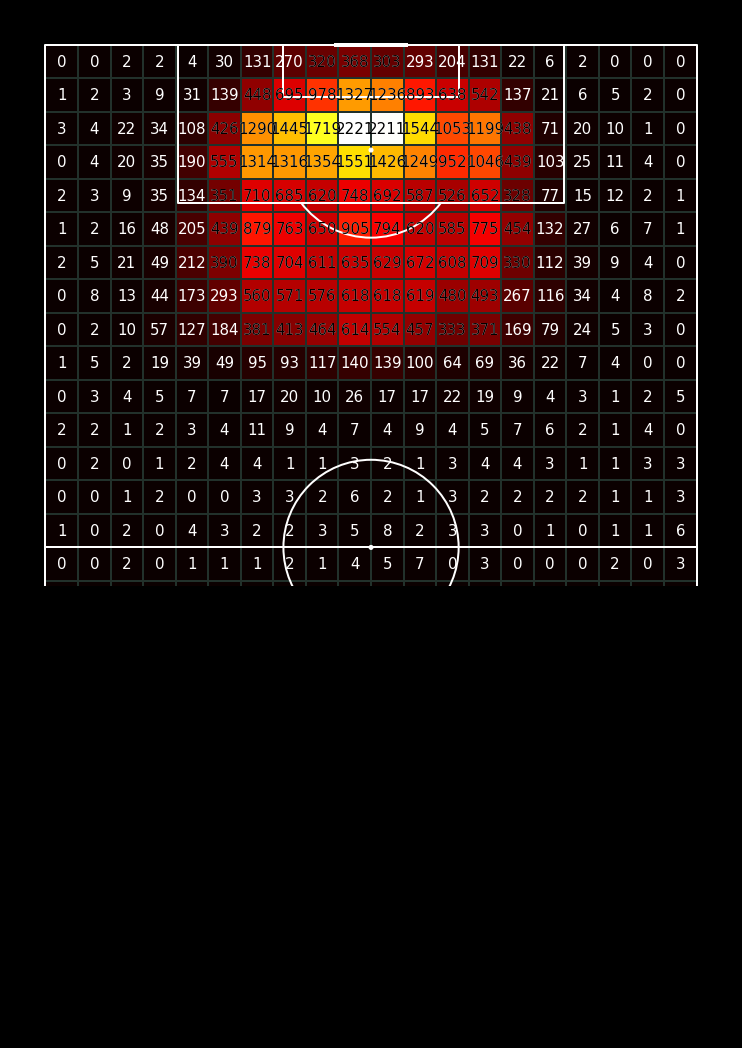

In [16]:
plt.style.use('dark_background')
pitch = VerticalPitch(pitch_type='uefa', half=True, line_zorder=2)
fig, ax = pitch.draw(figsize=(16, 12))
bs = pitch.bin_statistic(df_all_shots.x, df_all_shots.y, statistic='count', bins=(30, 20))
pcm = pitch.heatmap(bs, ax=ax, cmap='hot', edgecolors='#22312b')
bs['statistic'] = np.nan_to_num(bs['statistic'])
bs['statistic'] = (bs['statistic']).astype(np.int32)
annotation = pitch.label_heatmap(bs, color='white', fontsize=15, ax=ax, ha='center', va='center', zorder=3)
mask = bs['statistic'] > 300
bs['statistic'] = bs['statistic'].astype(str)
bs['statistic'][~mask] = ''
annotation = pitch.label_heatmap(bs, color='black', fontsize=15, ax=ax, ha='center', va='center', zorder=4)
fig.savefig(os.path.join(cwd, 'figures', '17_number_of_shots_by_location.png'),
            bbox_inches = 'tight', pad_inches = 0.2)

Create Shot Zones

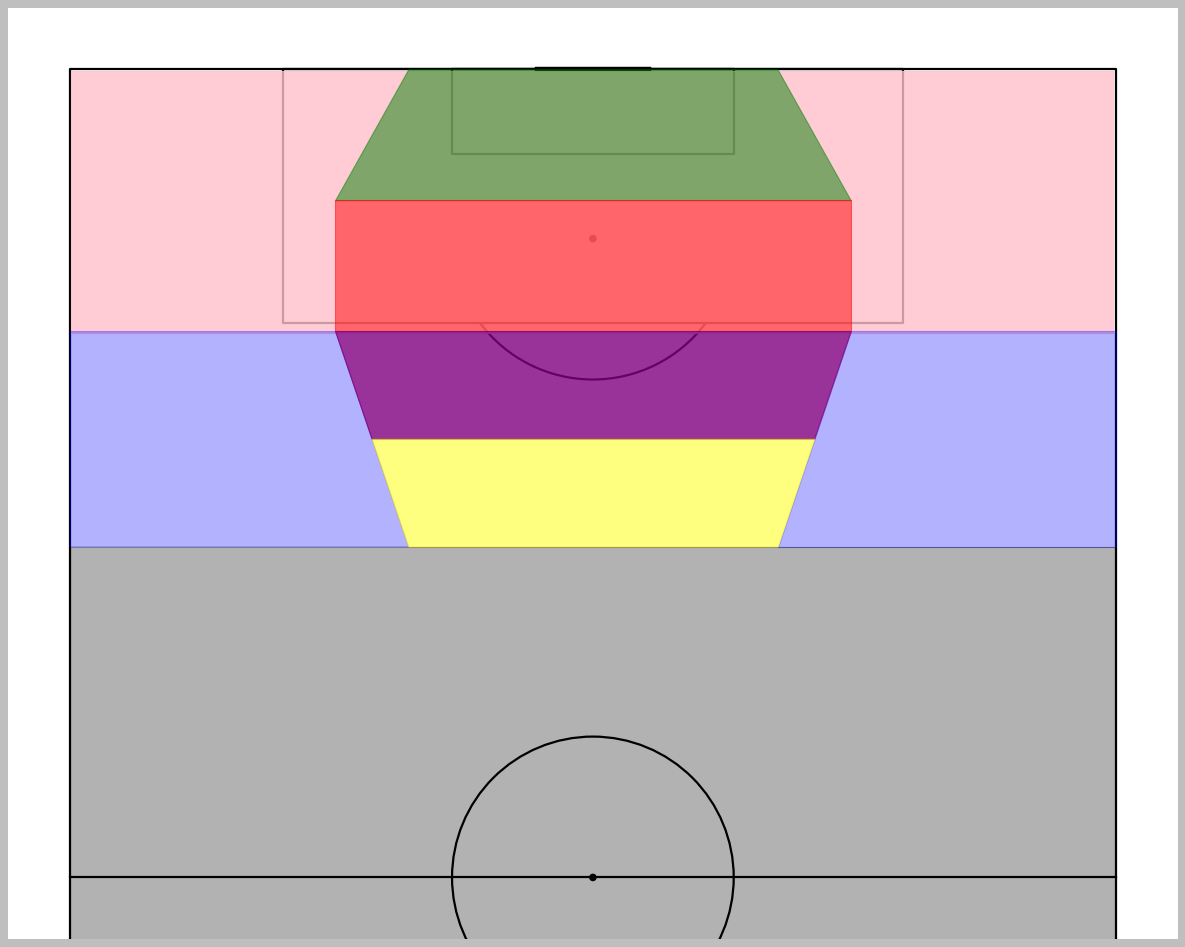

In [17]:
plt.style.use('classic')
pitch = VerticalPitch(pitch_type='uefa', half=True)
fig, ax = pitch.draw(figsize=(16, 12))
z1 = np.array([[96.5,17.25],
                [105, 22],
                [105, 0],
                [88, 0],
                [88, 17.25]])
z2 = np.array([[96.5,50.75],
                [105, 46],
                [105, 68],
                [88, 68],
                [88, 50.75]])
z3 = np.array([[96.5, 50.75],
                [96.5, 17.25],
                [105, 22],
                [105, 46]])
z4 = np.array([[88, 50.75],
                [88, 17.25],
                [96.5, 17.25],
                [96.5, 50.75]])
z5 = np.array([[74, 22],
                [74, 0],
                [88, 0],
                [88, 17.25]])
z6 = np.array([[74, 46],
                [74, 68],
                [88, 68],
                [88, 50.75]])
z7 = np.array([[81, 48.375],
                [81, 19.625],
                [88, 17.25],
                [88, 50.75]])
z8 = np.array([[74, 46],
                [74, 22],
                [81, 19.625],
                [81, 48.375]])
z9 = np.array([[0, 68],
                [0, 0],
                [74, 0],
                [74, 68]])
z10 = np.array([[87.9, 67.9],
                [87.9, 0.2],
                [104.9, 0.2],
                [104.9, 67.9]])
hull1 = pitch.convexhull(z10[:,0], z10[:,1])
poly = pitch.polygon(hull1, ax=ax, edgecolor='pink', facecolor='pink', alpha=0.8)
hull3 = pitch.convexhull(z3[:,0], z3[:,1])
poly = pitch.polygon(hull3, ax=ax, edgecolor='green', facecolor='green', alpha=0.5)
hull4 = pitch.convexhull(z4[:,0], z4[:,1])
poly = pitch.polygon(hull4, ax=ax, edgecolor='red', facecolor='red', alpha=0.5)
hull = pitch.convexhull(z5[:,0], z5[:,1])
poly = pitch.polygon(hull, ax=ax, edgecolor='blue', facecolor='blue', alpha=0.3)
hull6 = pitch.convexhull(z6[:,0], z6[:,1])
poly = pitch.polygon(hull6, ax=ax, edgecolor='blue', facecolor='blue', alpha=0.3)
hull7 = pitch.convexhull(z7[:,0], z7[:,1])
poly = pitch.polygon(hull7, ax=ax, edgecolor='purple', facecolor='purple', alpha=0.8)
hull8 = pitch.convexhull(z8[:,0], z8[:,1])
poly = pitch.polygon(hull8, ax=ax, edgecolor='yellow', facecolor='yellow', alpha=0.5)
hull9 = pitch.convexhull(z9[:,0], z9[:,1])
poly = pitch.polygon(hull9, ax=ax, edgecolor='black', facecolor='black', alpha=0.3)
z1 = geom.Polygon(z1)
z2 = geom.Polygon(z2)
z3 = geom.Polygon(z3)
z4 = geom.Polygon(z4)
z5 = geom.Polygon(z5)
z6 = geom.Polygon(z6)
z7 = geom.Polygon(z7)
z8 = geom.Polygon(z8)
z9 = geom.Polygon(z9)

Add Shot Zones to the DF Shots

In [18]:
shot_loc = geom.MultiPoint(df_all_shots[['x', 'y']].values)
z1_shot = [point.intersects(z1) for point in shot_loc]
z2_shot = [point.intersects(z2) for point in shot_loc]
z3_shot = [point.intersects(z3) for point in shot_loc]
z4_shot = [point.intersects(z4) for point in shot_loc]
z5_shot = [point.intersects(z5) for point in shot_loc]
z6_shot = [point.intersects(z6) for point in shot_loc]
z7_shot = [point.intersects(z7) for point in shot_loc]
z8_shot = [point.intersects(z8) for point in shot_loc]
z9_shot = [point.intersects(z9) for point in shot_loc]
df_all_shots['z1'] = z1_shot
df_all_shots['z2'] = z2_shot
df_all_shots['z3'] = z3_shot
df_all_shots['z4'] = z4_shot
df_all_shots['z5'] = z5_shot
df_all_shots['z6'] = z6_shot
df_all_shots['z7'] = z7_shot
df_all_shots['z8'] = z8_shot
df_all_shots['z9'] = z9_shot
df_all_shots.loc[(df_all_shots.z1 == True), 'shot_zone'] = 'Zone 1'
df_all_shots.loc[(df_all_shots.z2 == True), 'shot_zone'] = 'Zone 1'
df_all_shots.loc[(df_all_shots.z3 == True), 'shot_zone'] = 'Zone 2'
df_all_shots.loc[(df_all_shots.z4 == True), 'shot_zone'] = 'Zone 3'
df_all_shots.loc[(df_all_shots.z5 == True), 'shot_zone'] = 'Zone 4'
df_all_shots.loc[(df_all_shots.z6 == True), 'shot_zone'] = 'Zone 4'
df_all_shots.loc[(df_all_shots.z7 == True), 'shot_zone'] = 'Zone 5'
df_all_shots.loc[(df_all_shots.z8 == True), 'shot_zone'] = 'Zone 6'
df_all_shots.loc[(df_all_shots.z9 == True), 'shot_zone'] = 'Zone 7'
df_all_shots.drop(['z1', 'z2', 'z3','z4', 'z5', 'z6','z7', 'z8', 'z9'], axis=1, inplace=True)
df_all_shots

,match_id,statsbomb_id,eventSec,period,goal,statsbomb_team_id,player_id_statsbomb,shot_type_name,x,y,...,n_angle,goalkeeper_x,goalkeeper_y,dataset,wyscout_id,wyscout_team_id,player_id_wyscout,smart_pass,match_moment,shot_zone
0,2275099,4f985308-bf76-4a5d-860c-93537b4a49e3,7.476000,1.0,False,974.0,10251.0,open_play,91.3500,42.415,...,1.0,117.4,37.9,statsbomb,NaN,NaN,NaN,NaN,0-15,Zone 3
1,7471,7e68fa7c-4e44-4b3a-ab8a-9ff1da69eacc,8.489000,1.0,False,766.0,5044.0,open_play,79.6250,41.650,...,2.0,119.0,41.0,statsbomb,NaN,NaN,NaN,NaN,0-15,Zone 6
2,19788,bfb97b05-b013-4344-83a7-da6e19b57c05,10.515000,1.0,False,966.0,15628.0,open_play,78.7500,28.050,...,2.0,119.0,40.0,statsbomb,NaN,NaN,NaN,NaN,0-15,Zone 6
3,7571,25f7433a-e83b-4960-a619-7c991b872952,10.920000,1.0,False,787.0,5661.0,open_play,84.0000,45.900,...,1.0,120.0,41.0,statsbomb,NaN,NaN,NaN,NaN,0-15,Zone 5
4,266142,aeb61371-c08d-4a3f-ad1c-6ec102a4259e,11.399000,1.0,False,213.0,6672.0,open_play,90.3875,20.655,...,2.0,118.9,42.5,statsbomb,NaN,NaN,NaN,NaN,0-15,Zone 3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43367,2499820,NaN,3307.255167,2.0,False,NaN,NaN,penalty,93.4500,34.000,...,NaN,NaN,NaN,wyscout,203362731.0,1644.0,7929.0,None,75-90,Zone 3
43368,2499739,NaN,3310.186437,2.0,False,NaN,NaN,throw_in,91.3500,46.920,...,NaN,NaN,NaN,wyscout,182137485.0,1659.0,9277.0,None,75-90,Zone 3
43369,2516750,NaN,3389.861176,2.0,False,NaN,NaN,open_play,92.4000,27.200,...,NaN,NaN,NaN,wyscout,182026562.0,2463.0,127685.0,False,75-90,Zone 3
43370,2499820,NaN,3446.055301,2.0,False,NaN,NaN,open_play,93.4500,20.400,...,NaN,NaN,NaN,wyscout,203362910.0,1623.0,145692.0,False,75-90,Zone 3


Add wich number of shot is any shot for:
    
* The team on an specific shot zone
* The player on an specific shot zone
* The team in general
* The player in general

In [19]:
df_all_shots['shot_number'] = df_all_shots.groupby(['match_id','team_id'])['minute'].rank(method="first", ascending=True)
df_all_shots['shot_zone_number'] = df_all_shots.groupby(['match_id','team_id','shot_zone'])['minute'].rank(method="first", ascending=True)
df_all_shots['shot_player_number'] = df_all_shots.groupby(['match_id','team_id','player_id'])['minute'].rank(method="first", ascending=True)
df_all_shots['shot_zone_player_number'] = df_all_shots.groupby(['match_id','team_id','player_id','shot_zone'])['minute'].rank(method="first", ascending=True)
df_all_shots

,match_id,statsbomb_id,eventSec,period,goal,statsbomb_team_id,player_id_statsbomb,shot_type_name,x,y,...,wyscout_id,wyscout_team_id,player_id_wyscout,smart_pass,match_moment,shot_zone,shot_number,shot_zone_number,shot_player_number,shot_zone_player_number
0,2275099,4f985308-bf76-4a5d-860c-93537b4a49e3,7.476000,1.0,False,974.0,10251.0,open_play,91.3500,42.415,...,NaN,NaN,NaN,NaN,0-15,Zone 3,1.0,1.0,1.0,1.0
1,7471,7e68fa7c-4e44-4b3a-ab8a-9ff1da69eacc,8.489000,1.0,False,766.0,5044.0,open_play,79.6250,41.650,...,NaN,NaN,NaN,NaN,0-15,Zone 6,1.0,1.0,1.0,1.0
2,19788,bfb97b05-b013-4344-83a7-da6e19b57c05,10.515000,1.0,False,966.0,15628.0,open_play,78.7500,28.050,...,NaN,NaN,NaN,NaN,0-15,Zone 6,1.0,1.0,1.0,1.0
3,7571,25f7433a-e83b-4960-a619-7c991b872952,10.920000,1.0,False,787.0,5661.0,open_play,84.0000,45.900,...,NaN,NaN,NaN,NaN,0-15,Zone 5,1.0,1.0,1.0,1.0
4,266142,aeb61371-c08d-4a3f-ad1c-6ec102a4259e,11.399000,1.0,False,213.0,6672.0,open_play,90.3875,20.655,...,NaN,NaN,NaN,NaN,0-15,Zone 3,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43367,2499820,NaN,3307.255167,2.0,False,NaN,NaN,penalty,93.4500,34.000,...,203362731.0,1644.0,7929.0,None,75-90,Zone 3,11.0,5.0,1.0,1.0
43368,2499739,NaN,3310.186437,2.0,False,NaN,NaN,throw_in,91.3500,46.920,...,182137485.0,1659.0,9277.0,None,75-90,Zone 3,9.0,4.0,1.0,1.0
43369,2516750,NaN,3389.861176,2.0,False,NaN,NaN,open_play,92.4000,27.200,...,182026562.0,2463.0,127685.0,False,75-90,Zone 3,17.0,3.0,2.0,1.0
43370,2499820,NaN,3446.055301,2.0,False,NaN,NaN,open_play,93.4500,20.400,...,203362910.0,1623.0,145692.0,False,75-90,Zone 3,9.0,5.0,2.0,1.0


Add part of the season and part of the tournament

In [20]:
df_all_shots['competition_games'] = 38
df_all_shots.loc[(df_all_shots['competition_name'] == "FA Women's Super League"), 'competition_games'] = 22
df_all_shots.loc[(df_all_shots['competition_name'] == 'NWSL'), 'competition_games'] = 20
df_all_shots.loc[(df_all_shots['competition_name'] == 'FIFA World Cup') | (df_all_shots['competition_name'] == 'UEFA Euro') |
                 (df_all_shots['competition_name'] == "Women's World Cup"), 'competition_games'] = 3
df_all_shots.loc[(df_all_shots['competition_name'] == 'Bundesliga'), 'competition_games'] = 34
df_all_shots

,match_id,statsbomb_id,eventSec,period,goal,statsbomb_team_id,player_id_statsbomb,shot_type_name,x,y,...,wyscout_team_id,player_id_wyscout,smart_pass,match_moment,shot_zone,shot_number,shot_zone_number,shot_player_number,shot_zone_player_number,competition_games
0,2275099,4f985308-bf76-4a5d-860c-93537b4a49e3,7.476000,1.0,False,974.0,10251.0,open_play,91.3500,42.415,...,NaN,NaN,NaN,0-15,Zone 3,1.0,1.0,1.0,1.0,22
1,7471,7e68fa7c-4e44-4b3a-ab8a-9ff1da69eacc,8.489000,1.0,False,766.0,5044.0,open_play,79.6250,41.650,...,NaN,NaN,NaN,0-15,Zone 6,1.0,1.0,1.0,1.0,20
2,19788,bfb97b05-b013-4344-83a7-da6e19b57c05,10.515000,1.0,False,966.0,15628.0,open_play,78.7500,28.050,...,NaN,NaN,NaN,0-15,Zone 6,1.0,1.0,1.0,1.0,22
3,7571,25f7433a-e83b-4960-a619-7c991b872952,10.920000,1.0,False,787.0,5661.0,open_play,84.0000,45.900,...,NaN,NaN,NaN,0-15,Zone 5,1.0,1.0,1.0,1.0,3
4,266142,aeb61371-c08d-4a3f-ad1c-6ec102a4259e,11.399000,1.0,False,213.0,6672.0,open_play,90.3875,20.655,...,NaN,NaN,NaN,0-15,Zone 3,1.0,1.0,1.0,1.0,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43367,2499820,NaN,3307.255167,2.0,False,NaN,NaN,penalty,93.4500,34.000,...,1644.0,7929.0,None,75-90,Zone 3,11.0,5.0,1.0,1.0,38
43368,2499739,NaN,3310.186437,2.0,False,NaN,NaN,throw_in,91.3500,46.920,...,1659.0,9277.0,None,75-90,Zone 3,9.0,4.0,1.0,1.0,38
43369,2516750,NaN,3389.861176,2.0,False,NaN,NaN,open_play,92.4000,27.200,...,2463.0,127685.0,False,75-90,Zone 3,17.0,3.0,2.0,1.0,34
43370,2499820,NaN,3446.055301,2.0,False,NaN,NaN,open_play,93.4500,20.400,...,1623.0,145692.0,False,75-90,Zone 3,9.0,5.0,2.0,1.0,38


In [21]:
df_all_shots['competition_%'] = df_all_shots['match_week'] / df_all_shots['competition_games']
df_all_shots.loc[(df_all_shots['competition_type'] == "Cup"), 'competition_part'] = 'knockout'
df_all_shots.loc[(df_all_shots['competition_type'] == "Cup") & (df_all_shots['match_week'] <= 3), 'competition_part'] = 'group'
df_all_shots.loc[(df_all_shots['competition_type'] == "Cup") & (df_all_shots['match_week'] == 0), 
                 'competition_part'] = 'knockout'
df_all_shots.loc[(df_all_shots['competition_type'] == "League") & (df_all_shots['competition_%'] >= 0.66),
                 'competition_part'] = 'final'
df_all_shots.loc[(df_all_shots['competition_type'] == "League") & (df_all_shots['competition_%'] <= 0.33),
                 'competition_part'] = 'start'
df_all_shots.loc[(df_all_shots['competition_type'] == "League") & (df_all_shots['competition_%'] > 0.33) &
                 (df_all_shots['competition_%'] < 0.66), 'competition_part'] = 'middle'
df_all_shots

,match_id,statsbomb_id,eventSec,period,goal,statsbomb_team_id,player_id_statsbomb,shot_type_name,x,y,...,smart_pass,match_moment,shot_zone,shot_number,shot_zone_number,shot_player_number,shot_zone_player_number,competition_games,competition_%,competition_part
0,2275099,4f985308-bf76-4a5d-860c-93537b4a49e3,7.476000,1.0,False,974.0,10251.0,open_play,91.3500,42.415,...,NaN,0-15,Zone 3,1.0,1.0,1.0,1.0,22,0.045455,start
1,7471,7e68fa7c-4e44-4b3a-ab8a-9ff1da69eacc,8.489000,1.0,False,766.0,5044.0,open_play,79.6250,41.650,...,NaN,0-15,Zone 6,1.0,1.0,1.0,1.0,20,0.750000,final
2,19788,bfb97b05-b013-4344-83a7-da6e19b57c05,10.515000,1.0,False,966.0,15628.0,open_play,78.7500,28.050,...,NaN,0-15,Zone 6,1.0,1.0,1.0,1.0,22,0.636364,middle
3,7571,25f7433a-e83b-4960-a619-7c991b872952,10.920000,1.0,False,787.0,5661.0,open_play,84.0000,45.900,...,NaN,0-15,Zone 5,1.0,1.0,1.0,1.0,3,1.000000,group
4,266142,aeb61371-c08d-4a3f-ad1c-6ec102a4259e,11.399000,1.0,False,213.0,6672.0,open_play,90.3875,20.655,...,NaN,0-15,Zone 3,1.0,1.0,1.0,1.0,38,0.815789,final
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43367,2499820,NaN,3307.255167,2.0,False,NaN,NaN,penalty,93.4500,34.000,...,None,75-90,Zone 3,11.0,5.0,1.0,1.0,38,0.289474,start
43368,2499739,NaN,3310.186437,2.0,False,NaN,NaN,throw_in,91.3500,46.920,...,None,75-90,Zone 3,9.0,4.0,1.0,1.0,38,0.078947,start
43369,2516750,NaN,3389.861176,2.0,False,NaN,NaN,open_play,92.4000,27.200,...,False,75-90,Zone 3,17.0,3.0,2.0,1.0,34,0.058824,start
43370,2499820,NaN,3446.055301,2.0,False,NaN,NaN,open_play,93.4500,20.400,...,False,75-90,Zone 3,9.0,5.0,2.0,1.0,38,0.289474,start


In [22]:
df_all_shots.drop(['eventSec', 'period'], axis=1, inplace=True)
df_all_shots = df_all_shots[['match_id','dataset','statsbomb_id','wyscout_id','statsbomb_team_id','wyscout_team_id',
                             'team_id','team_name','player_id_statsbomb','player_id_wyscout','player_id','Name','firstName',
                             'middleName','lastName','competition_gender','competition_name','competition_type','match_week',
                             'competition_part','H_A_column','minute','match_moment','x','y','visible_angle','middle_angle',
                             'distance_to_goal','distance_visible_angle','log_distance_to_goal','shot_type_name',
                             'shot_one_on_one','shot_open_goal','under_pressure','counter_attack','fast_break','strong_foot',
                             'body_part_name','shot_zone','shot_number','shot_zone_number','shot_player_number',
                             'shot_zone_player_number','assist_type','pass_end_y','pass_end_x','carry_length','pass_switch',
                             'pass_cross','pass_cut_back','pass_height_name','pass_technique_name','smart_pass','area_shot',
                             'area_goal','n_angle','goalkeeper_x','goalkeeper_y','players','players_rival','goal']]

In [23]:
df_all_shots = df_all_shots[df_all_shots.H_A_column.notnull()].copy()

In [24]:
df_all_shots.reset_index(drop=True, inplace=True)

Save data

In [25]:
df_all_shots.to_parquet(os.path.join(cwd, 'data', 'shots.parquet'))

Info

In [26]:
df_all_shots.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65555 entries, 0 to 65554
Data columns (total 61 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   match_id                 65555 non-null  int64  
 1   dataset                  65555 non-null  object 
 2   statsbomb_id             22183 non-null  object 
 3   wyscout_id               43372 non-null  float64
 4   statsbomb_team_id        22183 non-null  float64
 5   wyscout_team_id          43372 non-null  float64
 6   team_id                  65555 non-null  int64  
 7   team_name                65555 non-null  object 
 8   player_id_statsbomb      22183 non-null  float64
 9   player_id_wyscout        43372 non-null  float64
 10  player_id                65555 non-null  int64  
 11  Name                     65555 non-null  object 
 12  firstName                65555 non-null  object 
 13  middleName               65555 non-null  object 
 14  lastName              

Compare datasets

Text(0.5, 1.0, 'Wyscout')

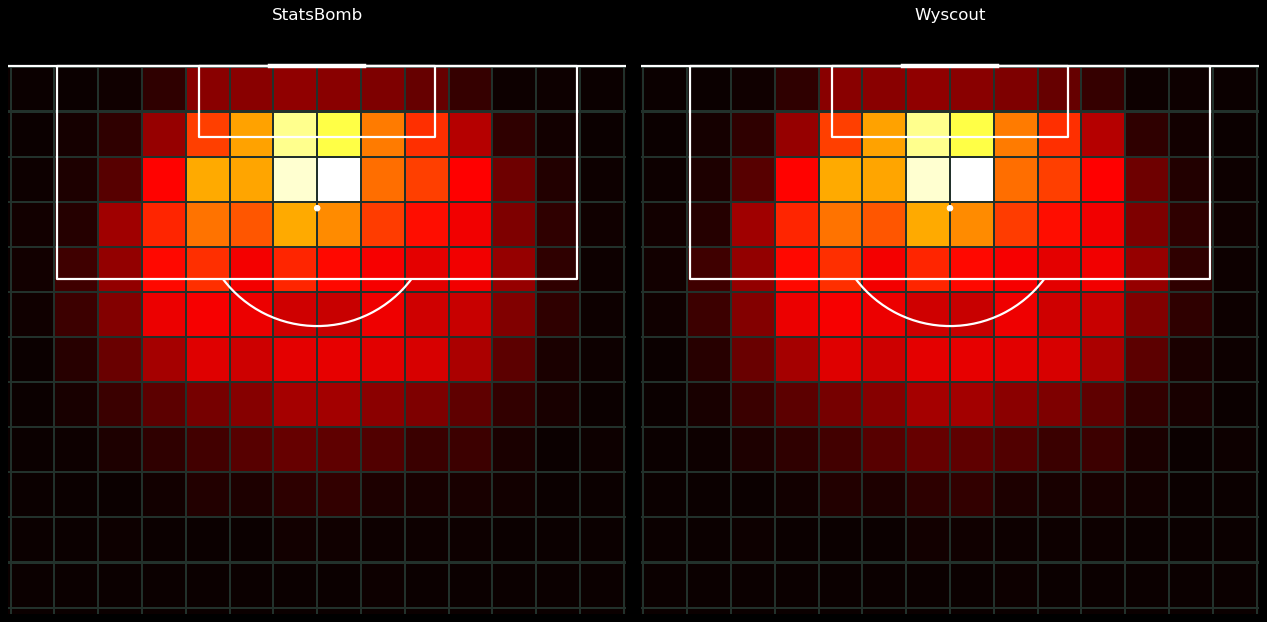

In [27]:
plt.style.use('dark_background')
pitch = VerticalPitch(pitch_type='uefa', layout=(1, 2), pad_left=-10, pad_right=-10, pad_bottom=-10,
              half=True, line_zorder=2)
fig, ax = pitch.draw(figsize=(16, 12),ncols=2)
ax = ax.ravel()
bs = pitch.bin_statistic(df_all_shots[df_all_shots.dataset=='statsbomb'].x,
                         df_all_shots[df_all_shots.dataset=='statsbomb'].y, 
                         statistic='count', bins=(30, 20))
bs['statistic'] = (bs['statistic']).astype(np.int32)
pcm = pitch.heatmap(bs, ax=ax[0], cmap='hot', edgecolors='#22312b')
ax[0].set_title('StatsBomb', fontsize=15, pad=-4)
bs['statistic'] = (bs['statistic']).astype(np.int32)
pcm = pitch.heatmap(bs, ax=ax[1], cmap='hot', edgecolors='#22312b')
ax[1].set_title('Wyscout', fontsize=15, pad=-4)

In [28]:
df_all_shots.groupby('dataset').fast_break.mean()

dataset
statsbomb    0.033314
wyscout      0.041501
Name: fast_break, dtype: float64

In [29]:
df_all_shots.groupby('dataset').counter_attack.mean()

dataset
statsbomb    0.045981
wyscout      0.051715
Name: counter_attack, dtype: float64

In [30]:
df_all_shots.groupby('dataset').visible_angle.describe()

,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
statsbomb,22183.0,0.468884,0.297645,0.0,0.275164,0.365379,0.575696,3.141593
wyscout,43372.0,0.409006,0.250948,0.0,0.247140,0.320078,0.502020,3.141593


In [31]:
df_all_shots.groupby('dataset').middle_angle.describe()

,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
statsbomb,22183.0,0.487217,0.331382,0.0,0.213903,0.452154,0.718425,1.570796
wyscout,43372.0,0.474547,0.313858,0.0,0.212610,0.445236,0.689349,1.570796


In [32]:
df_all_shots.groupby('dataset').distance_to_goal.describe()

,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
statsbomb,22183.0,16.651107,7.734010,0.6,10.5,15.7,22.2,70.8
wyscout,43372.0,18.927218,8.374191,0.7,12.5,17.7,25.5,75.4


In [33]:
df_all_shots.groupby('dataset').distance_visible_angle.describe()

,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
statsbomb,22183.0,6.106431,1.153021,0.0,5.610815,6.460622,6.971367,9.738937
wyscout,43372.0,6.180561,1.089970,0.0,5.725457,6.529107,7.007013,7.316065


In [34]:
df_all_shots.groupby('dataset').pass_switch.value_counts()

dataset    pass_switch
statsbomb  False          14579
           True            1000
wyscout    False          26459
           True            2059
Name: pass_switch, dtype: int64

In [35]:
df_all_shots.groupby('dataset').pass_cut_back.value_counts()

dataset    pass_cut_back
statsbomb  False            15162
           True               417
wyscout    False            27570
           True               948
Name: pass_cut_back, dtype: int64

In [36]:
df_all_shots.groupby('dataset').pass_cross.value_counts()

dataset    pass_cross
statsbomb  False         12602
           True           2977
wyscout    False         21160
           True           7358
Name: pass_cross, dtype: int64

In [37]:
df_all_shots.smart_pass.value_counts()

False    26162
True      2356
Name: smart_pass, dtype: int64

In [38]:
df_all_shots.groupby('dataset').assist_type.value_counts()

dataset    assist_type
statsbomb  pass           15579
           recovery        2315
           clearance       1775
           direct          1322
           rebound         1192
wyscout    pass           28518
           recovery        6525
           rebound         3352
           direct          2595
           clearance       2382
Name: assist_type, dtype: int64

In [39]:
df_all_shots.groupby('dataset').shot_type_name.value_counts()

dataset    shot_type_name  
statsbomb  open_play           14388
           corner               2594
           throw_in             2040
           free_kick            1565
           direct_set_piece     1322
           penalty               274
wyscout    open_play           29180
           corner               5272
           throw_in             4242
           free_kick            2083
           direct_set_piece     2048
           penalty               547
Name: shot_type_name, dtype: int64

In [40]:
df_all_shots.groupby('dataset').shot_zone.value_counts()

dataset    shot_zone
statsbomb  Zone 3        8305
           Zone 2        5907
           Zone 5        4483
           Zone 6        1935
           Zone 4         658
           Zone 7         469
           Zone 1         426
wyscout    Zone 3       16262
           Zone 2        8232
           Zone 6        6787
           Zone 5        6719
           Zone 4        2743
           Zone 7        1677
           Zone 1         952
Name: shot_zone, dtype: int64

In [41]:
df_all_shots.groupby('dataset').shot_number.value_counts()

dataset    shot_number
statsbomb  1.0            1756
           2.0            1747
           3.0            1729
           4.0            1696
           5.0            1640
                          ... 
wyscout    35.0              3
           36.0              2
           37.0              2
           38.0              1
           39.0              1
Name: shot_number, Length: 82, dtype: int64

In [42]:
df_all_shots.groupby('dataset').shot_player_number.value_counts()

dataset    shot_player_number
statsbomb  1.0                   10857
           2.0                    5352
           3.0                    2777
           4.0                    1470
           5.0                     808
           6.0                     450
           7.0                     239
           8.0                     118
           9.0                      57
           10.0                     32
           11.0                     15
           12.0                      7
           13.0                      1
wyscout    1.0                   23592
           2.0                   10820
           3.0                    5033
           4.0                    2271
           5.0                     973
           6.0                     399
           7.0                     164
           8.0                      66
           9.0                      30
           10.0                     16
           11.0                      6
           12.0                   

In [43]:
df_all_shots.groupby('dataset').shot_zone_number.value_counts()

dataset    shot_zone_number
statsbomb  1.0                  7204
           2.0                  4780
           3.0                  3314
           4.0                  2325
           5.0                  1583
           6.0                  1090
           7.0                   700
           8.0                   440
           9.0                   279
           10.0                  170
           11.0                  111
           12.0                   69
           13.0                   43
           14.0                   28
           15.0                   20
           16.0                   12
           17.0                    9
           18.0                    6
wyscout    1.0                 16432
           2.0                 10356
           3.0                  6522
           4.0                  4028
           5.0                  2478
           6.0                  1515
           7.0                   897
           8.0                   496
          

In [44]:
df_all_shots.groupby('dataset').shot_zone_player_number.value_counts()

dataset    shot_zone_player_number
statsbomb  1.0                        16831
           2.0                         3764
           3.0                         1105
           4.0                          334
           5.0                          104
           6.0                           27
           7.0                           11
           8.0                            5
           9.0                            2
wyscout    1.0                        35364
           2.0                         6238
           3.0                         1354
           4.0                          317
           5.0                           68
           6.0                           23
           7.0                            6
           8.0                            2
Name: shot_zone_player_number, dtype: int64

In [45]:
df_all_shots.groupby('dataset').competition_part.value_counts()

dataset    competition_part
statsbomb  middle               6635
           start                6237
           final                6030
           group                2272
           knockout             1009
wyscout    middle              14284
           final               14242
           start               13590
           group                 878
           knockout              378
Name: competition_part, dtype: int64